In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal
import cusignal
import pandas as pd
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import transformation_funcs as tfs
torch.cuda.set_device(0) 


def snomedConvert(code,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        df.columns = [codes[codes["SNOMED CT Code"] == int(x)].iloc[0]["Dx"] for x in df.columns]
        return df
df = pd.read_csv("data/WFDB_CPSC2018.csv")
codes =  pd.read_csv("data/codes.csv",sep=";")
# df.columns = [codes[codes["SNOMED CT Code"] == x].iloc[0]["Dx"] for x in df.columns]
np.sum(codes["SNOMED CT Code"] == int(df.columns[0]))

1

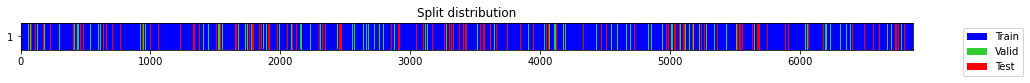

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [2]:
X = np.load('./data/big_numpy_datasets/WFDB_CPSC2018.npy', mmap_mode='c')
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])

y = snomedConvert(df)
y = y[y.columns[0]].to_numpy()
splits = get_splits(y, valid_size=.1,test_size=0.1, stratify=True, random_state=23, shuffle=True)
df = pd.read_csv("data/WFDB_CPSC2018.csv").drop(columns=["headers","leads"])
y = snomedConvert(df)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

# Test out transformations here

In [81]:
class BandPass(Transform):
    # resampling (probably want downsampling)
    def __init__(self, sample_rate =500, low_cut=45, high_cut=100, **kwargs):
        self.sr = sample_rate
        self.low_cut = low_cut
        self.high_cut = high_cut
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        xf = torchaudio.functional.highpass_biquad(x,sample_rate=self.sr,cutoff_freq = self.high_cut)
        xf = torchaudio.functional.lowpass_biquad(xf,sample_rate=self.sr,cutoff_freq = self.low_cut)
        return xf

In [104]:
class BandPass(Transform):
    # resampling (probably want downsampling)
    def __init__(self, sample_rate =500, low_cut=45, high_cut=100, **kwargs):
        self.sr = sample_rate
        self.low_cut = low_cut
        self.high_cut = high_cut
        super().__init__(**kwargs)
    def encodes(self, o: TSTensor):
        for i in range(len(o)):
            sig = torchaudio.functional.highpass_biquad(o[i],sample_rate=self.sr,cutoff_freq = self.high_cut)
            o[i] = torchaudio.functional.lowpass_biquad(sig,sample_rate=self.sr,cutoff_freq = self.low_cut)
        return o

CPU times: user 20.1 s, sys: 6.41 s, total: 26.5 s
Wall time: 9.54 s


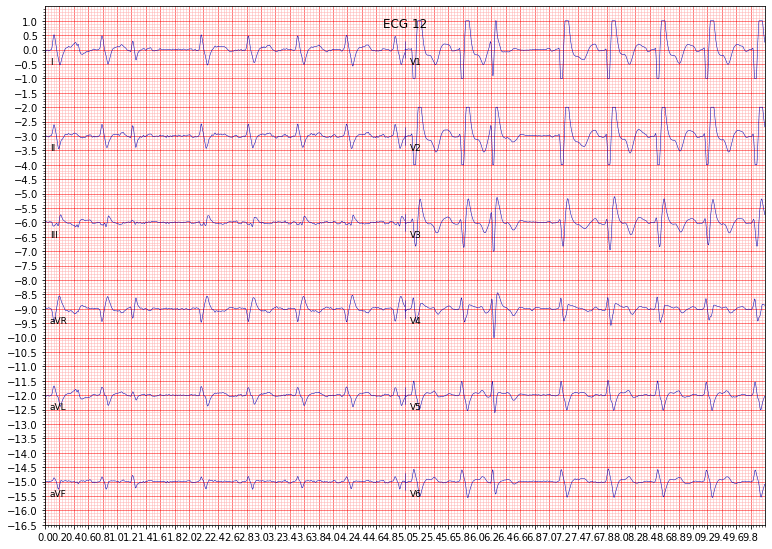

In [105]:
%%time
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Normalize(),
                BandPass(sample_rate =500, low_cut=100, high_cut=3),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
#               tfs.Scale(scale_factor=1)
             ]
dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=splits) # inplace=True by default
dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
metrics =[ precision_multi, recall_multi, specificity_multi, F1_multi] 

for batch in dls.train:
    x = batch[0][0]
    break
ecg_plot.plot(x.cpu())


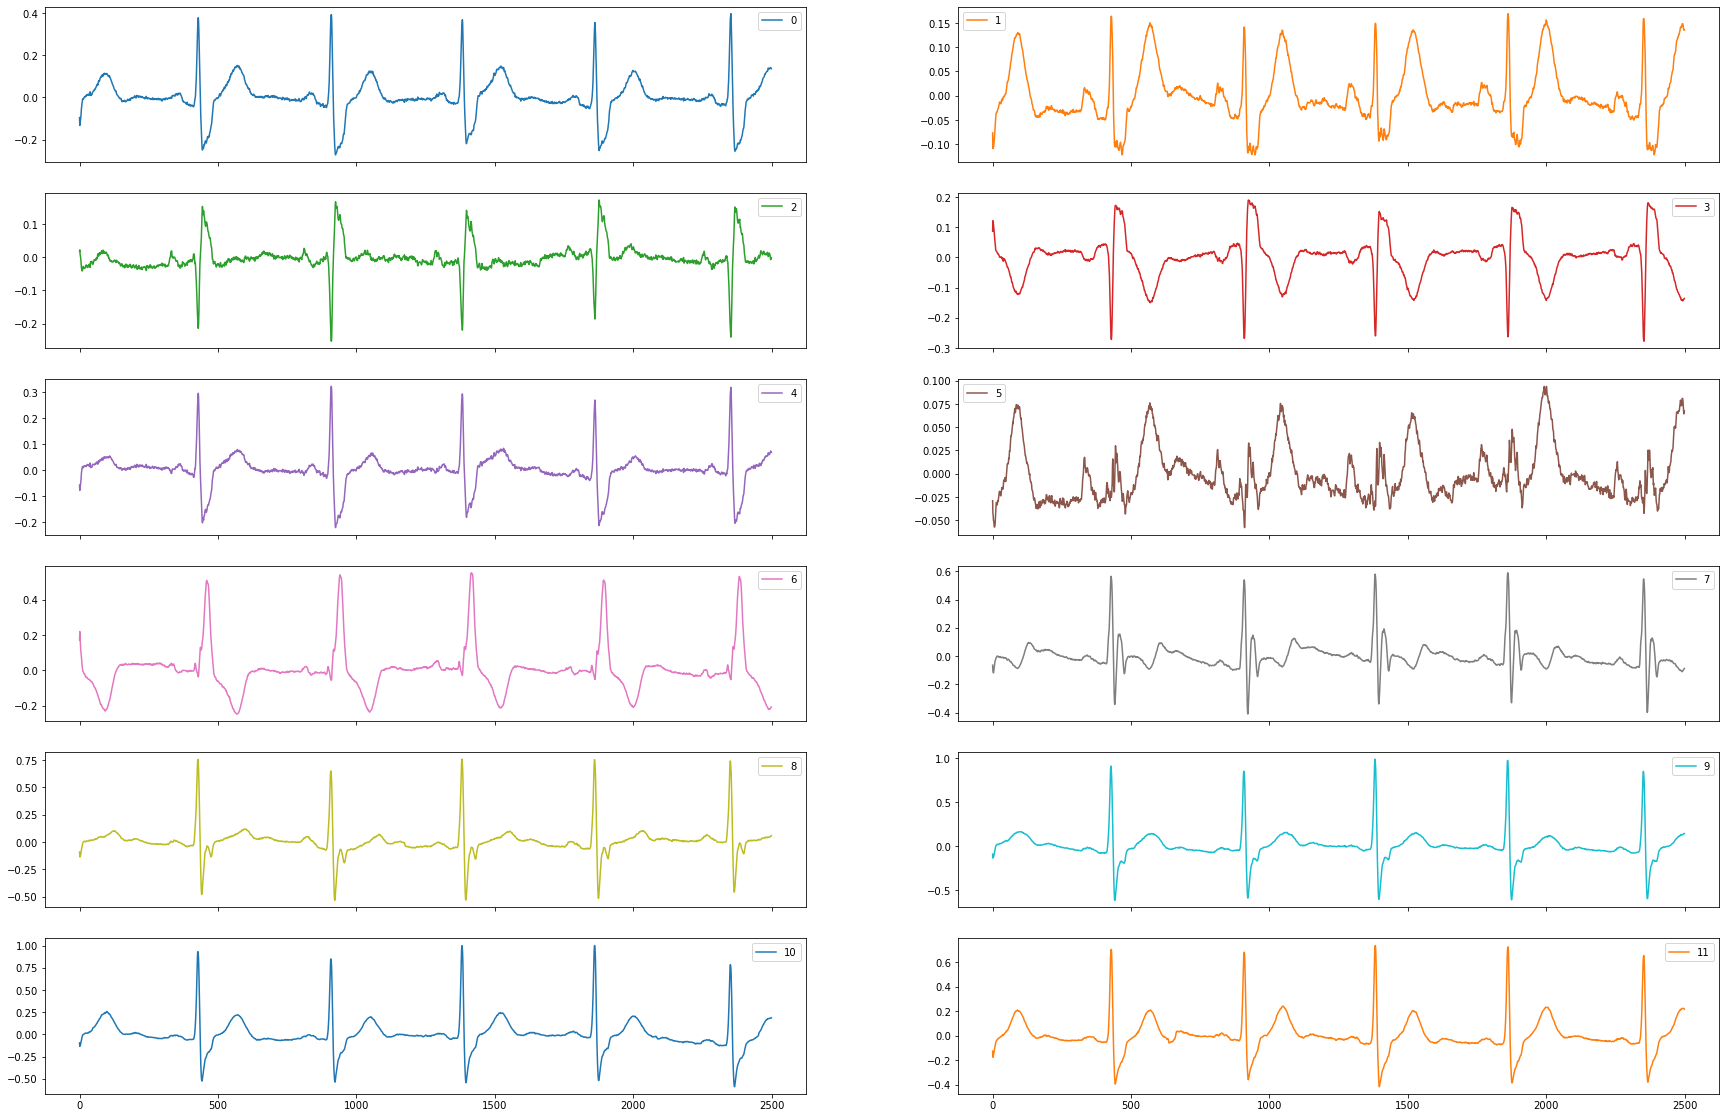

In [40]:
fig = pd.DataFrame(x).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

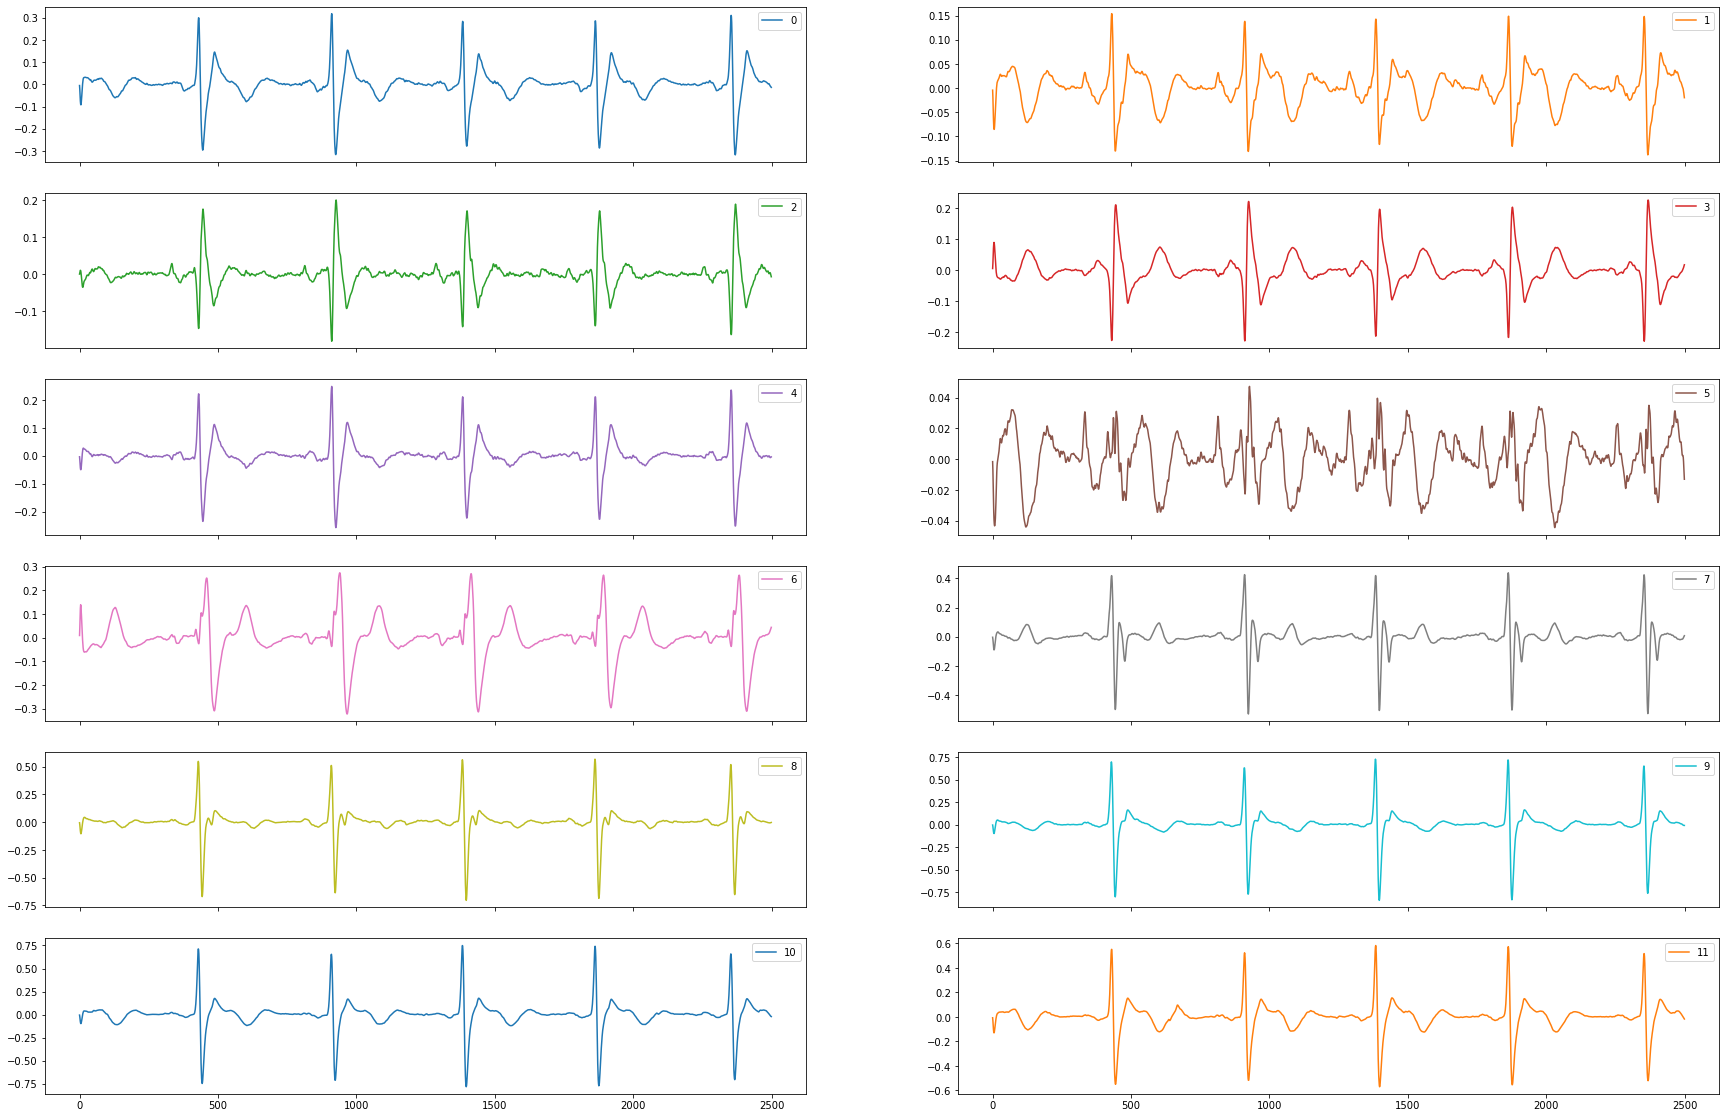

In [46]:

xf = torchaudio.functional.highpass_biquad(x,sample_rate=500,cutoff_freq = 3)
xf = torchaudio.functional.lowpass_biquad(xf,sample_rate=500,cutoff_freq = 45)
fig = pd.DataFrame(xf).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

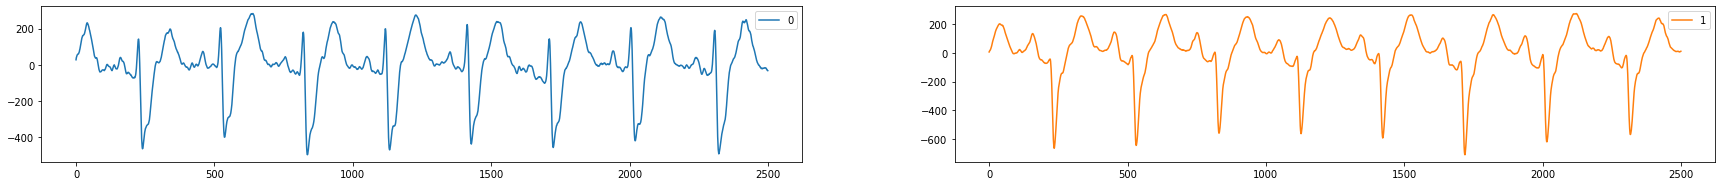

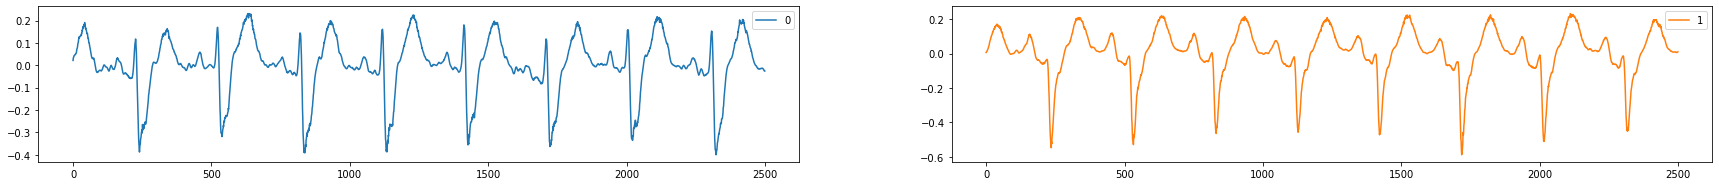

In [111]:
# diff = xb[0]-changed[0]

pd.DataFrame(changed[0][0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))
# fig = pd.DataFrame(diff[0:2]).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))